In [1]:
import pandas as pd
import os
import torch
import json
import numpy as np

/home/lbcb02/anaconda3/envs/master_37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%run ../Config.ipynb

In [3]:
config = Config()

#### Rmsd's 

In [4]:
rmsd = pd.read_csv(f"{config.data}/rmsd_refined_set.csv") # rmsd

In [5]:
rmsd['pdb'].nunique()

3940

Obs: There is one pdb missing!

In [6]:
rmsd[rmsd['pdb'] == "4kz6"]['poserank'].value_counts()

2     1
3     1
6     1
7     1
8     1
10    1
Name: poserank, dtype: int64

In [14]:
import seaborn as sns

In [17]:
rmsd.head()

,pdb,poserank,RMSD
0,3oy8,1,5.27
1,3oy8,2,6.33
2,3oy8,3,6.42
3,3oy8,4,4.99
4,3oy8,5,8.00


<AxesSubplot:xlabel='poserank'>

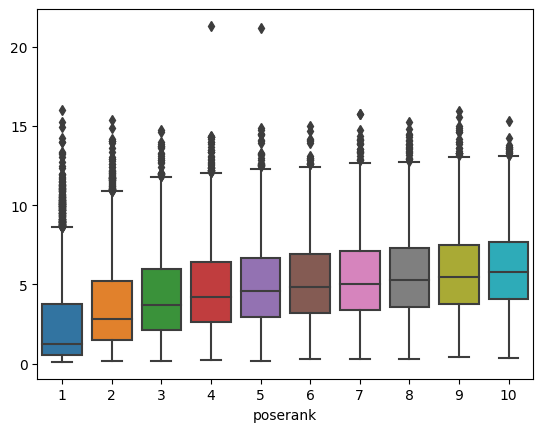

In [22]:
sns.boxplot(rmsd.pivot_table(index = 'pdb', columns = 'poserank', values = 'RMSD'))

Complexes are labeled as correct if they fall within 2.0 Angstroms heavy-atom RMSD of the reference ligand structure, a standard cutoff in the field (see e.g. Ref. 44). Correct poses are labeled “positive,” and those that fall outside the cutoff are labeled as “negative.”

#### Creating label 

In [7]:
label = rmsd.copy()

#### Score similarity 

In [37]:
score = pd.read_json(f"{config.data}/score.json").unstack().reset_index().rename(columns = {"level_0":"pdb", "level_1":"poserank", 0:'similarity'})

#### Merge

In [38]:
label = pd.merge(score, label, left_on= ['pdb','poserank'], right_on = ['pdb','poserank'], how = 'outer').drop_duplicates()

In [39]:
#label.sort_values('similarity', ascending = False).tail(30)

| score | rmsd |
|-------|------|
| rmsd < 2 | -10 |
| 2 < rmsd < 3 | -7 |
| rmsd > 3 | 0 |

| score | match |
|-------|-------|
| 79 | -10 |
| 70 | -7 |
| 66 | 0 |
| 42 | 0 |


#### Conditions

In [40]:
# Define the conditions and corresponding scores
conditions_rmsd = [ label['RMSD'] < 2
              ,(label['RMSD'] >= 2) & (label['RMSD'] < 3)
              , label['RMSD'] >= 3]

In [41]:
conditions_similarity = [ label['similarity'] >=80 
              ,(label['similarity'] >= 70) & (label['similarity'] < 80)
              #,(label['similarity'] >= 66) & (label['similarity'] < 70)
              , label['similarity'] < 70 ]

In [42]:
scores_rmsd       = [10, 7, 0]
scores_similarity = [10, 7, 0]

label['rmsd_weight'] = np.select(conditions_rmsd, scores_rmsd, default=np.nan)
label['similarity_weight'] = np.select(conditions_similarity, scores_similarity, default=np.nan)

#### Métrica 

$$
\frac{{\text{{score\_rmsd}} \times 0.5 + \text{{score\_match}} \times 0.5}}{{20}}
$$


In [43]:
label['weight'] = (label['rmsd_weight']*0.5 + label['similarity_weight']*0.5)/10
label['weight_similarity'] = (label['rmsd_weight']*0.3 + label['similarity_weight']*0.7)/10
label['weight_rmsd'] = (label['rmsd_weight']*0.7 + label['similarity_weight']*0.3)/10

In [44]:
label['weight'].value_counts()

0.00    1763
0.35     312
0.50     256
0.85      98
1.00      93
0.70      15
Name: weight, dtype: int64

In [45]:
label["label"] = label["weight"].apply(lambda x: 1 if x > 0.5 else 0)

In [46]:
label.head()

,pdb,poserank,similarity,RMSD,rmsd_weight,similarity_weight,weight,weight_similarity,weight_rmsd,label
0,4eor,1,77.272727,4.34,0.0,7.0,0.35,0.49,0.21,0
1,4eor,2,5.454545,1.16,10.0,0.0,0.50,0.30,0.70,0
2,4eor,3,9.090909,4.94,0.0,0.0,0.00,0.00,0.00,0
3,4eor,4,6.363636,4.92,0.0,0.0,0.00,0.00,0.00,0
4,4eor,5,5.454545,6.54,0.0,0.0,0.00,0.00,0.00,0


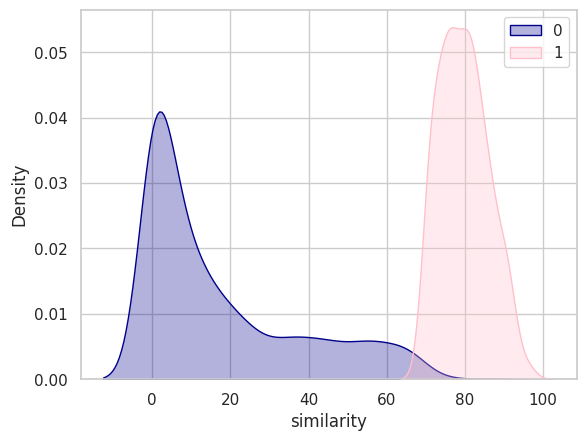

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots()

# Plot density plots for each class with increased transparency
sns.kdeplot(data=label[label['label'] == 0], x='similarity', fill=True, color='darkblue', alpha=0.3, ax=ax, label='0')
sns.kdeplot(data=label[label['label'] == 1], x='similarity', fill=True, color='pink', alpha=0.3, ax=ax, label='1')

# Show the legend
ax.legend()

# Display the plot
plt.show()


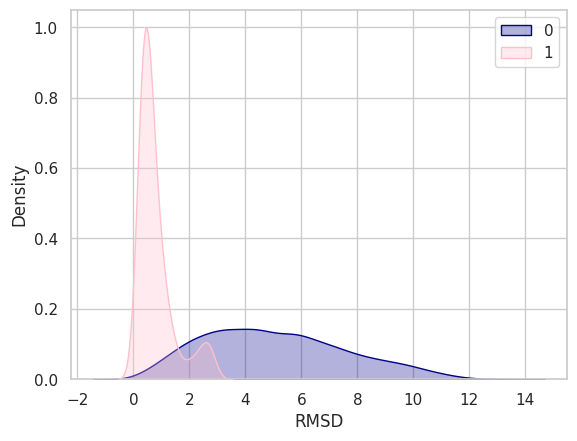

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots()

# Plot density plots for each class with increased transparency
sns.kdeplot(data=label[label['label'] == 0], x='RMSD', fill=True, color='darkblue', alpha=0.3, ax=ax, label='0')
sns.kdeplot(data=label[label['label'] == 1], x='RMSD', fill=True, color='pink', alpha=0.3, ax=ax, label='1')

# Show the legend
ax.legend()

# Display the plot
plt.show()


#### Stats

In [49]:
len(label['label'])

2840

In [50]:
label['pdb'].nunique()

284

In [51]:
label['label'].value_counts(1)

0    0.927465
1    0.072535
Name: label, dtype: float64

#### Creating dict 

In [52]:
# Create the nested dictionary
result_dict = {}
for index, row in label.iterrows():
    pdb = row['pdb']
    poserank = row['poserank']
    label = row['label']
    
    if pdb not in result_dict:
        result_dict[pdb] = {}
    
    result_dict[pdb][poserank] = label

In [53]:
print("label.json saved at:", config.data)

label.json saved at: ../Datahub/Data


In [25]:
# Assuming result_dict is your dictionary
with open(f"{config.data}/label.json", "w") as json_file:
    json.dump(result_dict, json_file)

In [26]:
# Assuming result_dict is your dictionary
with open(f"{config.data}/label.json", "r") as json_file:
    result = json_file.read()

In [27]:
result = pd.read_json(f"{config.data}/label.json")

In [28]:
result

,4eor,2qbq,3g2n,1ydr,3uev,2xnb,3qqs,1w4o,4jxs,3zsx,...,4ddh,3oe4,3g31,4jsz,3udh,4w9l,2cbv,4j28,2j78,3bgz
1,0,0,1,1,0,0,1,1,0,0,...,0,1,0,0,1,1,1,1,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Report 

#### Merge 

In [29]:
path_to_docked = "/home/lbcb02/Workspace/General data/docked/ex_50_bz_10_poses_10_v2"
lepton = pd.DataFrame(columns = ["pdb","class"])

for class_ in ["best","good","bad","verybad"]: 
    color_path = os.path.join(path_to_docked, class_)
    if os.path.exists(color_path):
        for pdb in os.listdir(color_path):
            lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
    else:
        print("Incorrect path")

In [59]:
#best_weight = label.sort_values(["pdb", "weight"], ascending = False).drop_duplicates("pdb", keep = "first")
#best_weight_similarity = label.sort_values(["pdb", "weight_similarity"], ascending = False).drop_duplicates("pdb", keep = "first")
#best_weight_rmsd = label.sort_values(["pdb", "weight_rmsd"], ascending = False).drop_duplicates("pdb", keep = "first")

In [60]:
#label.sort_values(["pdb", "weight"], ascending = False).head(30)

In [58]:
#merged_best_weight = pd.merge(best_weight, lepton, on = ['pdb'], how = "inner")
#merged_best_weight_similarity = pd.merge(best_weight_similarity, lepton, on = ['pdb'], how = "inner")
#merged_best_weight_rmsd = pd.merge(best_weight_rmsd, lepton, on = ['pdb'], how = "inner")

#### Functions 

In [259]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_count_distribution(data, x, hue):
    # Set the style for the plot
    sns.set(style="whitegrid")

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot a bar plot with hue for each class
    sns.countplot(data=data, x=x, hue=hue, palette='Set2')

    # Set the plot labels and title
    ax.set(xlabel='Class', ylabel='Count', title='Distribution of Classes with Score Hue')

    # Format x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    # Display the plot
    plt.show()

#### Distribuition 

In [55]:
#plot_count_distribution(data=merged_best, x='weight', hue='class')

In [56]:
#plot_count_distribution(data=merged_best_weight_similarity, x='weight_similarity', hue='class')

In [57]:
#plot_count_distribution(data=merged_best_weight_rmsd, x='weight_rmsd', hue='class')

In [54]:
#merged_best[(merged_best['class']=='best') & (merged_best['weight']==0.5)].head(10)

First the RMSD and the similarity metric is caulculated, 

| score | rmsd weight |
|-------|------|
| rmsd < 2 | -10 |
| 2 < rmsd < 3 | -7 |
| rmsd > 3 | 0 |

| score | match weight|
|-------|-------|
| > 80 | -10 |
| >= 70 | -7 |
| < 70 | 0| 


Then the score is thefined as 

$$
Score = \frac{{\text{{rmsd weight}} \times 0.3 + \text{{match weight}} \times 0.7}}{{20}}
$$

